In [1]:
#Some simple exploration that will look at the shape of each metric's distribution

In [2]:
#Get the subnational explorer metrics.
from google.cloud import bigquery
import pandas as pd
client = bigquery.Client(location=" europe-west2")

query = """
    SELECT AREACD, Indicator, Category, Value 
    FROM `ons-luda-data-prod.ingest_luda.20220201_subnational_indicators_explorer_p` 
    
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="europe-west2",
)  # API request - starts the query

all_metrics = query_job.to_dataframe()
metrics_wide = pd.pivot(all_metrics, values='Value', columns='Indicator', index='AREACD').reindex()

In [3]:
import scipy.stats
scipy.stats.skew(metrics_wide, axis=0, nan_policy='omit')
#Reminder: skew > 0  means left-skewed. skew < 0 means right skewed.
#scipy.stats.describe(metrics_wide, axis=0, nan_policy='omit')

masked_array(data=[-3.34535927,  0.59802624,  0.5832909 ,  0.30597945,
                   -0.51064481,  0.35377978, -0.15664353,  0.13579817,
                    0.13853628,  0.24154029,  4.39206854, 13.3379767 ,
                    2.22546343, -0.02273366, -0.18883812,  0.24959334,
                    1.44480098,  0.9563346 ,  0.14574758,  2.40693177,
                    2.47173261,  2.43134255,  0.80049716, -0.24157856,
                   -0.08958153],
             mask=False,
       fill_value=1e+20)

In [4]:
#For reference, the metrics are in this order.
list(metrics_wide)

['4G coverage provided by at least one mobile network provider',
 "5 year olds achieving 'expected level' on communication early learning goals",
 "5 year olds achieving 'expected level' on literacy early learning goals",
 "5 year olds achieving 'expected level' on maths early learning goals",
 'Adult (18+) overweight and obesity prevalance',
 'Adults that currently smoke cigarettes',
 'Average anxiety rating',
 'Average feeling that things done in life are worthwhile rating',
 'Average happiness rating',
 'Average life satisfaction rating',
 'Average travel time to nearest large employment centre (500+ employees) by bike',
 'Average travel time to nearest large employment centre (500+ employees) by car',
 'Average travel time to nearest large employment centre (500+ employees) by public transport or walking',
 'Children (4 to 5 years old) overweight and obesity prevalance',
 'Employment rate for 16 to 64 year olds',
 'Female healthy life expectancy',
 'Gross Value Added per hour worke

In [5]:
#So we can we some of these metrics have obviously skewed distributions.
skewtest = scipy.stats.skewtest(metrics_wide, axis=0, nan_policy='omit')
print(skewtest.pvalue < 0.05)
print(skewtest.pvalue)

[ True  True  True False  True  True False False False False  True  True
  True False False False  True  True False  True  True  True  True False
 False]
[2.22782020e-045 3.37797850e-003 4.14345250e-003 1.15804179e-001
 3.82414168e-004 5.94354861e-003 2.10709283e-001 2.74752595e-001
 2.65274311e-001 5.42130208e-002 1.45490074e-050 5.77336916e-107
 3.84368950e-027 8.70977021e-001 1.32817238e-001 1.28993829e-001
 2.33731183e-018 4.65620892e-011 3.71108164e-001 1.87267910e-028
 9.86557689e-029 2.89963681e-028 9.99074321e-009 2.11107550e-001
 5.07015796e-001]


In [6]:
#Can we get a list of metrics which appear to be correlated
corr = metrics_wide.corr()
n_metrics = corr.shape[0]
high_corr=[]
med_corr=[]
for i in range(n_metrics):
    for j in range(i+1, n_metrics):
        if abs(corr.iloc[i,j]) > 0.5:
               high_corr.append([corr.columns[i], corr.columns[j], corr.iloc[i,j]])
        elif abs(corr.iloc[i,j]) > 0.3:
               med_corr.append([corr.columns[i], corr.columns[j], corr.iloc[i,j]])
high_corr        


[["5 year olds achieving 'expected level' on communication early learning goals",
  "5 year olds achieving 'expected level' on literacy early learning goals",
  0.8318562486824137],
 ["5 year olds achieving 'expected level' on communication early learning goals",
  "5 year olds achieving 'expected level' on maths early learning goals",
  0.8834427620765944],
 ["5 year olds achieving 'expected level' on communication early learning goals",
  'Children (4 to 5 years old) overweight and obesity prevalance',
  -0.5026005038620167],
 ["5 year olds achieving 'expected level' on communication early learning goals",
  'Employment rate for 16 to 64 year olds',
  0.5205488565644147],
 ["5 year olds achieving 'expected level' on communication early learning goals",
  'Female healthy life expectancy',
  0.5179876551745638],
 ["5 year olds achieving 'expected level' on communication early learning goals",
  'Male healthy life expectancy',
  0.6042387436355481],
 ["5 year olds achieving 'expected le

In [7]:
len(high_corr)

45

In [26]:
len(high_corr[0][1])

71

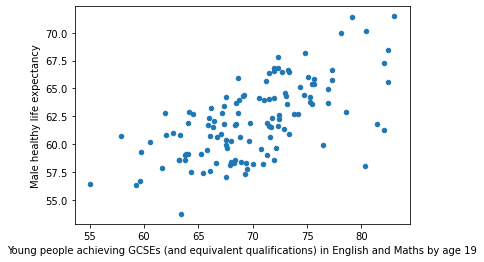

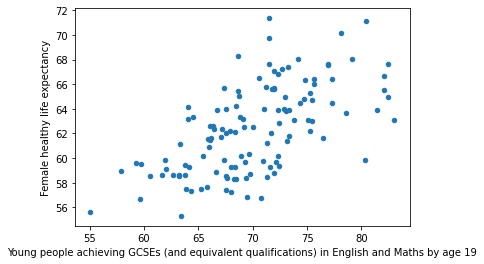

In [52]:
def plot_high_corr(i, invert=True, auto_choose_orientation=False):
    #Check the length of the labels. Maybe be easier to have the long one on the x axis.
    if auto_choose_orientation:
        if len(high_corr[i][1]) > len(high_corr[i][0]):
            invert = True
        else: 
            invert = False

    if invert:
        metrics_wide.plot.scatter(x=high_corr[i][1],
                                  y=high_corr[i][0])
    else:
        metrics_wide.plot.scatter(x=high_corr[i][0],
                                  y=high_corr[i][1])

#Now can look at pair 41 more easily, which is between HLE and childhood attainment.
plot_high_corr(41)
plot_high_corr(38)

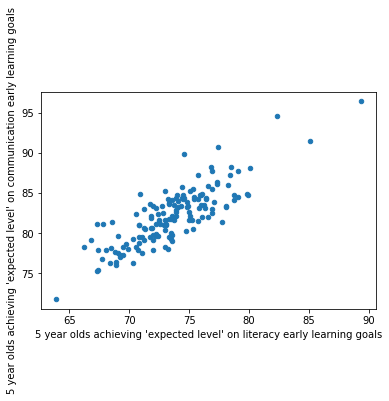

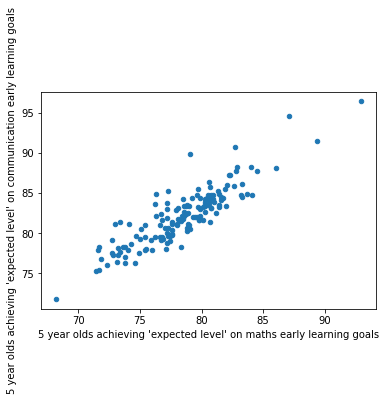

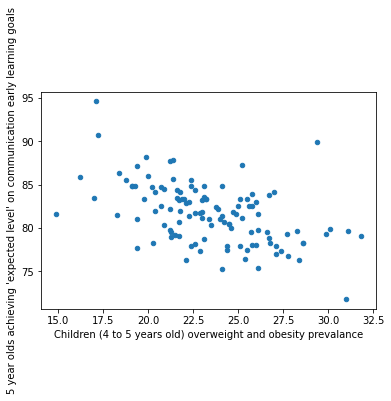

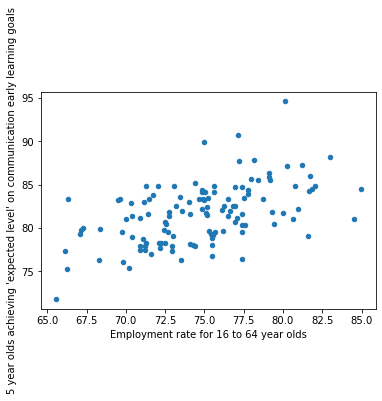

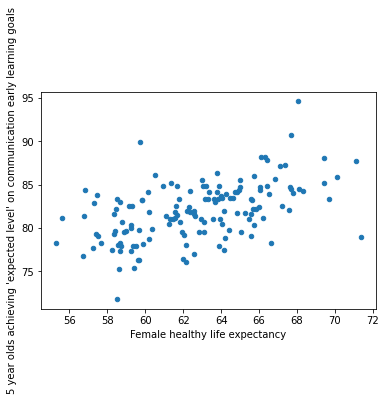

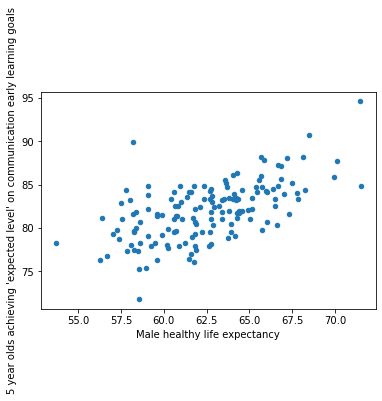

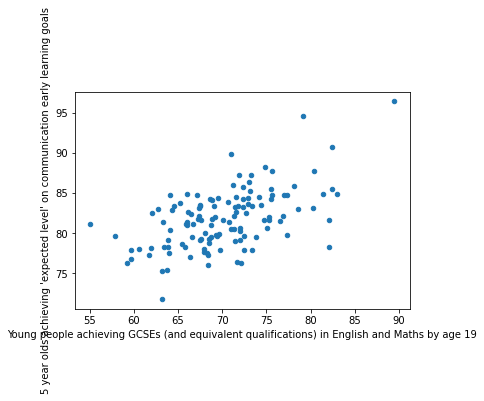

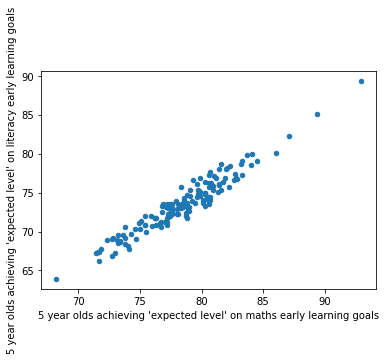

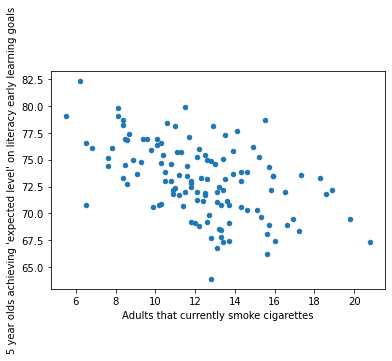

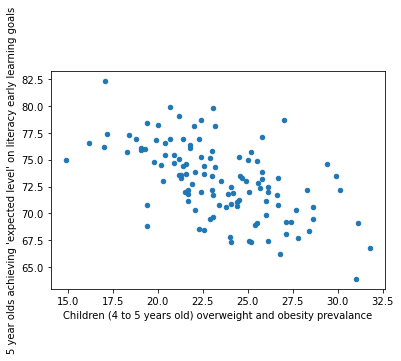

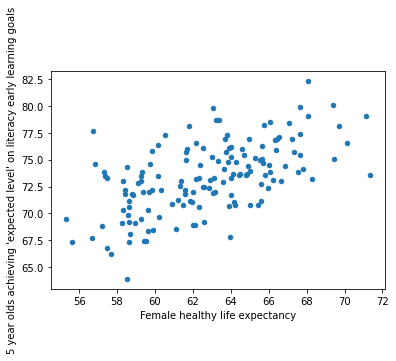

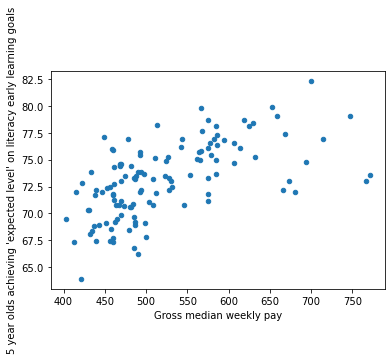

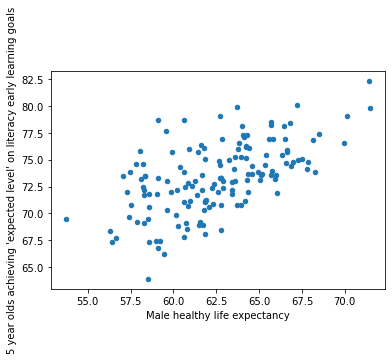

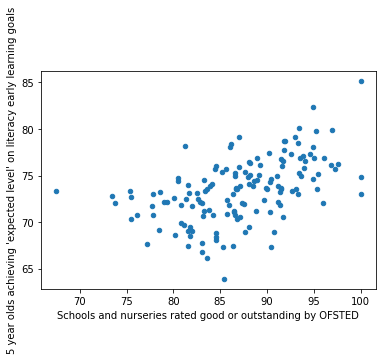

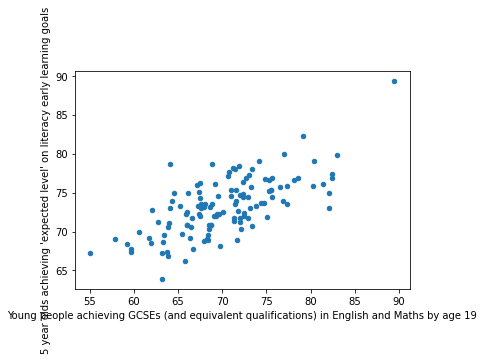

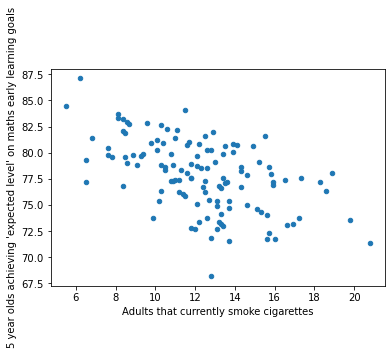

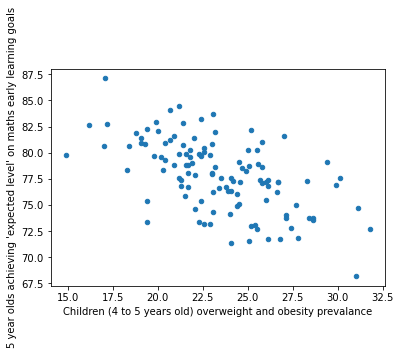

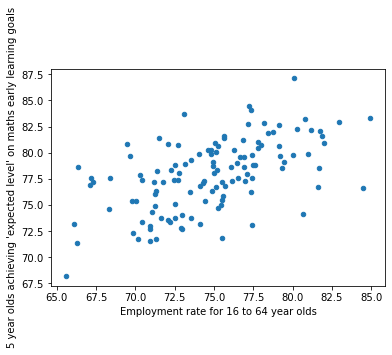

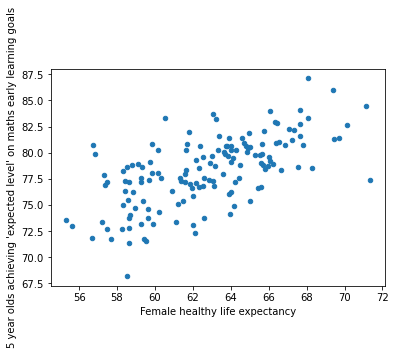

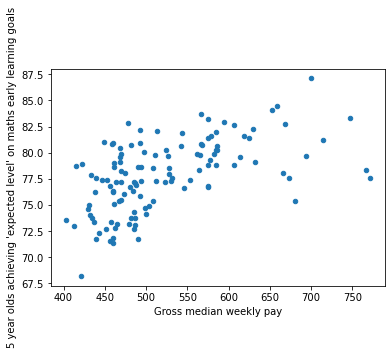

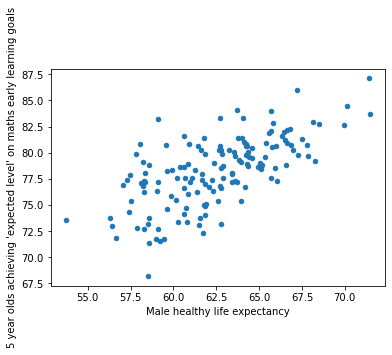

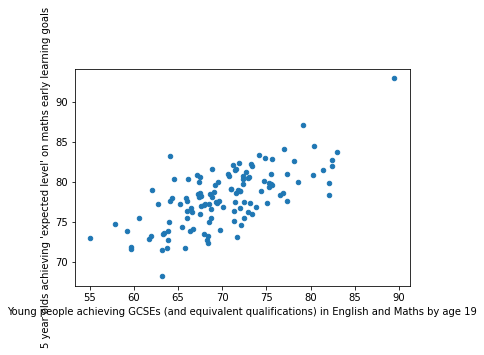

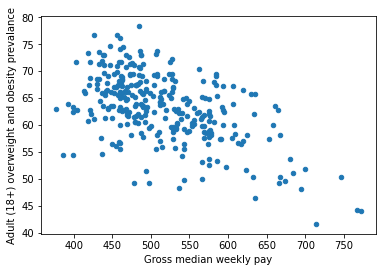

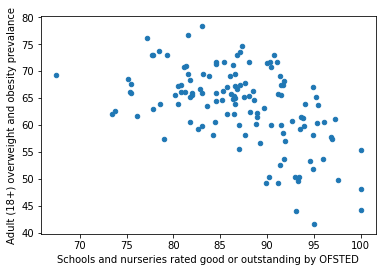

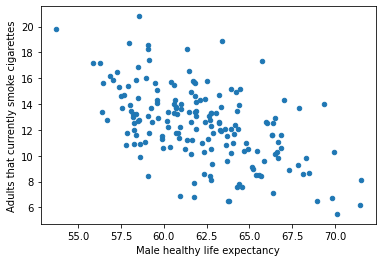

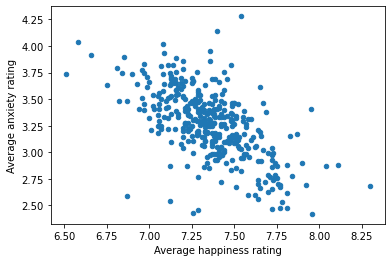

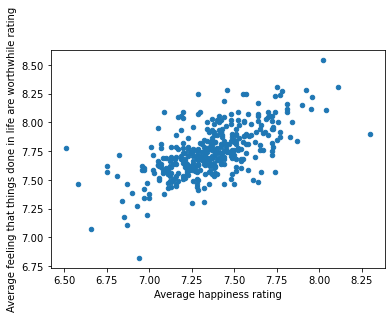

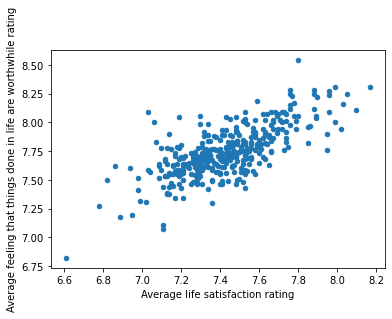

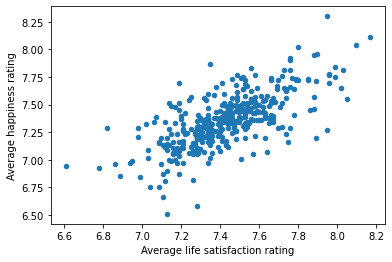

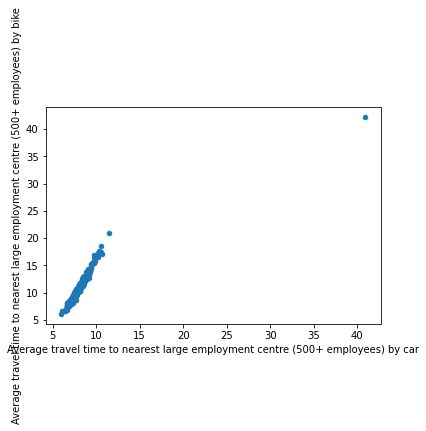

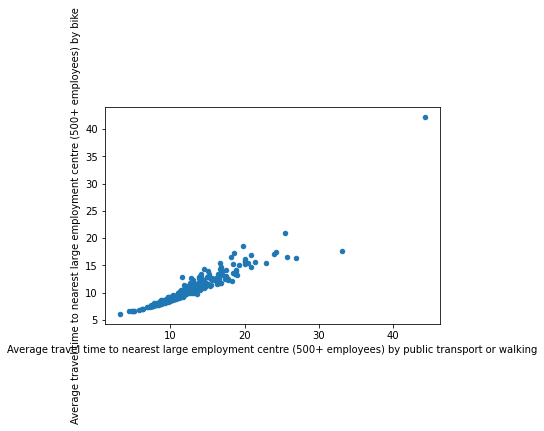

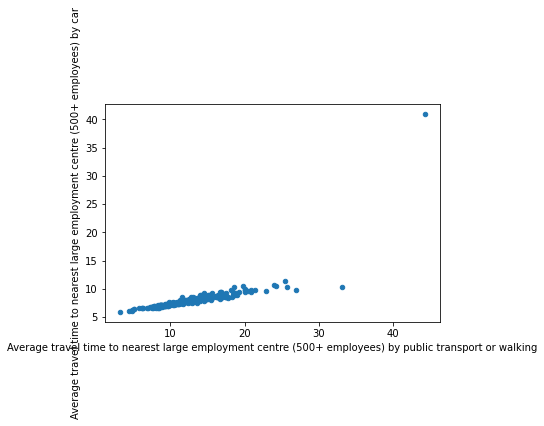

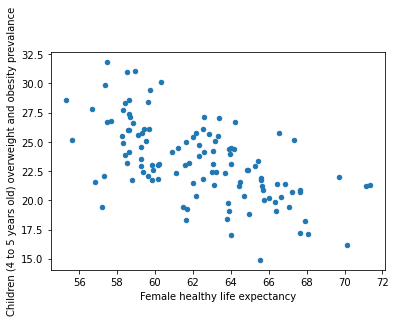

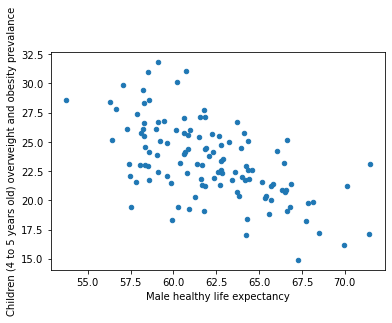

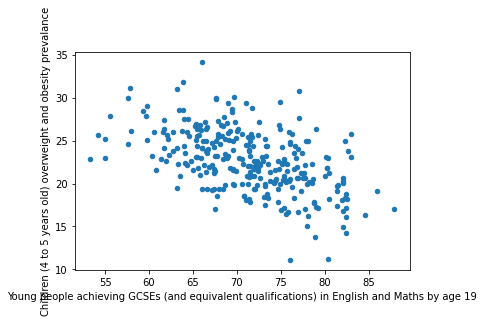

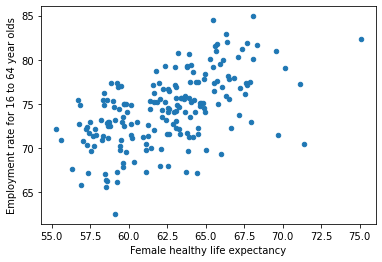

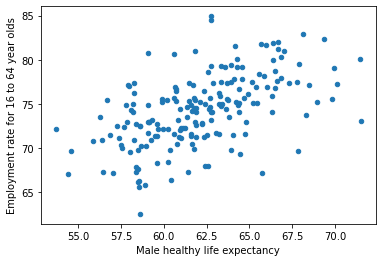

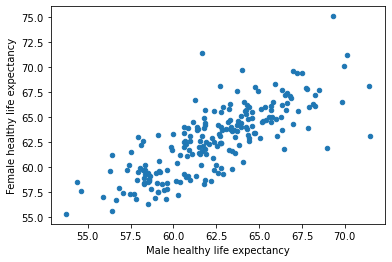

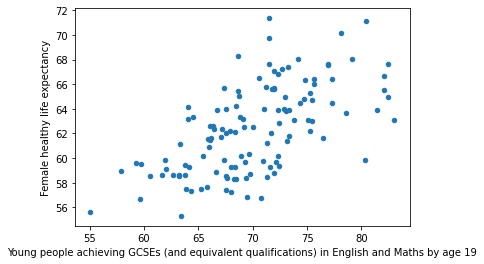

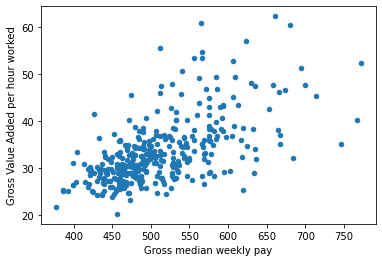

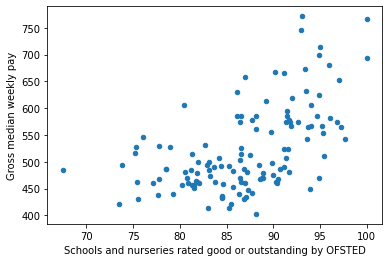

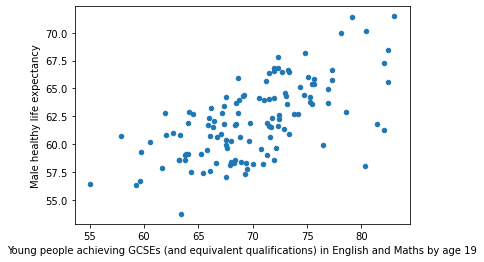

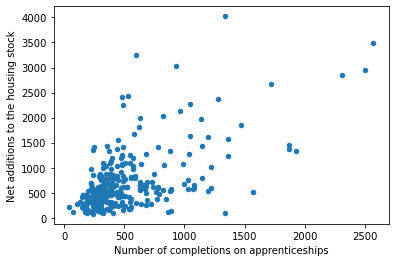

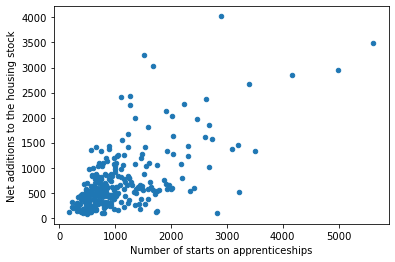

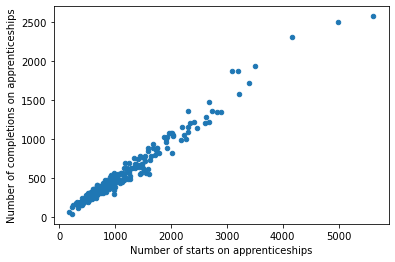

In [53]:
#Brute force plotting of interesting scatters.
for pair in range(len(high_corr)):
    plot_high_corr(pair)

In [ ]:
#Worth noting at this point on the correlations between apprenticeship starts/completions and housing stock:
#These are all totals, so to a large extent depend on the population of the LA area.
#Suspect these may be spurious, and that normalising by capita would be needed for this analysis.
#Relatedly, that these don't correlate with anything else is not conclusive.

<AxesSubplot:xlabel='Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19', ylabel='Male healthy life expectancy'>

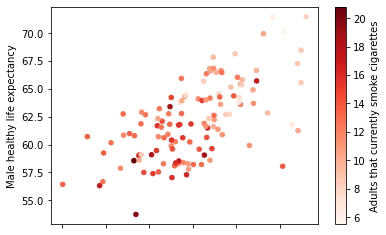

In [23]:
#A test to look for visualising a third helpful explanatory variable.
metrics_wide.plot.scatter(x="Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19",
                          y="Male healthy life expectancy",
                          c="Adults that currently smoke cigarettes", cmap='Reds')